# IT3100 AI Application Project
Name:       Pang Jen Herm, Sophie

Admin No.:  233760Y

## 1. Introduction
ANS Import & Export Pte Ltd is a manufacturer and distributor of non-food household goods sold through over 600 retail outlets in Singapore. 

The problem arises from inefficient manual tracking of product facings—specifically, how many SKUs are actually displayed in each outlet. 
The current manual process lacks scalability and real-time insights, which impacts sales performance. 

The problem I aim to solve focuses on optimising SKU displays and sales performance for the company. 
My goal is to build a Product Ranking Recommendation model that suggests the most suitable SKUs for each supermarket outlet based on predicted sales potential. This helps the sales merchandising manager to proactively recommend high-performing products to individual outlets based on historical trends and product performance.

By recommending the optimal SKUs for each outlet, I hope to increase shelf presence and reduce lost sales opportunities contributed to by the manual merchandising workflow. 

## 2. Data collection
Since the data provided by the company is insufficient for training a machine learning model, I opted to use an open-source retail sales dataset with relevant features that simulate the kind of data ANS would ideally have if they had a proper merchandising and POS system.

<b>Data source:</b> https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/data

### 🤔Why this dataset? 
I evaluated multiple open datasets and chose this one because...

| Dataset | Limitations |
|---------|-------------|
| [lovishbansal123/sales-of-a-supermarketonly](https://www.kaggle.com/datasets/lovishbansal123/sales-of-a-supermarketonly) | Only 3 outlets, generic product categories, no SKU IDs |
| [kzmontage/sales-from-different-stores](https://www.kaggle.com/datasets/kzmontage/sales-from-different-stores/data?select=Different_stores_data_V2.csv) | Only 3 months of data, fewer features |
| [roopacalistus/superstore](https://www.kaggle.com/datasets/roopacalistus/superstore/data) | No SKU IDs, very small dataset |
| **[rohitsahoo/sales-forecasting (Selected)](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/data)** | ✅ ~10k rows, ✅ unique SKUs, ✅ rich metadata including postal codes of outlets


### 🔄 <b>Dataset similarity to ANS business context </b>

The process at ANS involves tracking SKUs by outlet across the country.

The selected dataset contains region and postal data, allowing us to segment demand and simulate different outlet behaviors, which parallels ANS’s operations across varied retail chains like Sheng Siong, NTUC, and 7-Eleven.

It is also similar to the provided SKU list example dataset from the company which contains SKU IDs, SKU categories, and SKU descriptions.

In [49]:
import numpy as np
import pandas as pd
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install plotly
import plotly.express as px

# !pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## 3. Load and explore data

In [85]:
df = pd.read_csv('train.csv')
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (9800, 18)

Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales']

First few rows:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

This helps me check the data types and missing values. And it's useful for deciding if encoding or imputation is needed later.

In [87]:
df['Segment'].value_counts()

Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64

In [88]:
df['Region'].value_counts()

Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64

In [89]:
df['Category'].value_counts()

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64

In [90]:
df['Sub-Category'].value_counts()

Sub-Category
Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: count, dtype: int64

In [91]:
df['Postal Code'].value_counts()

Postal Code
10035.0    253
10024.0    225
10009.0    220
94122.0    195
10011.0    193
          ... 
32935.0      1
76248.0      1
32127.0      1
32503.0      1
72762.0      1
Name: count, Length: 626, dtype: int64

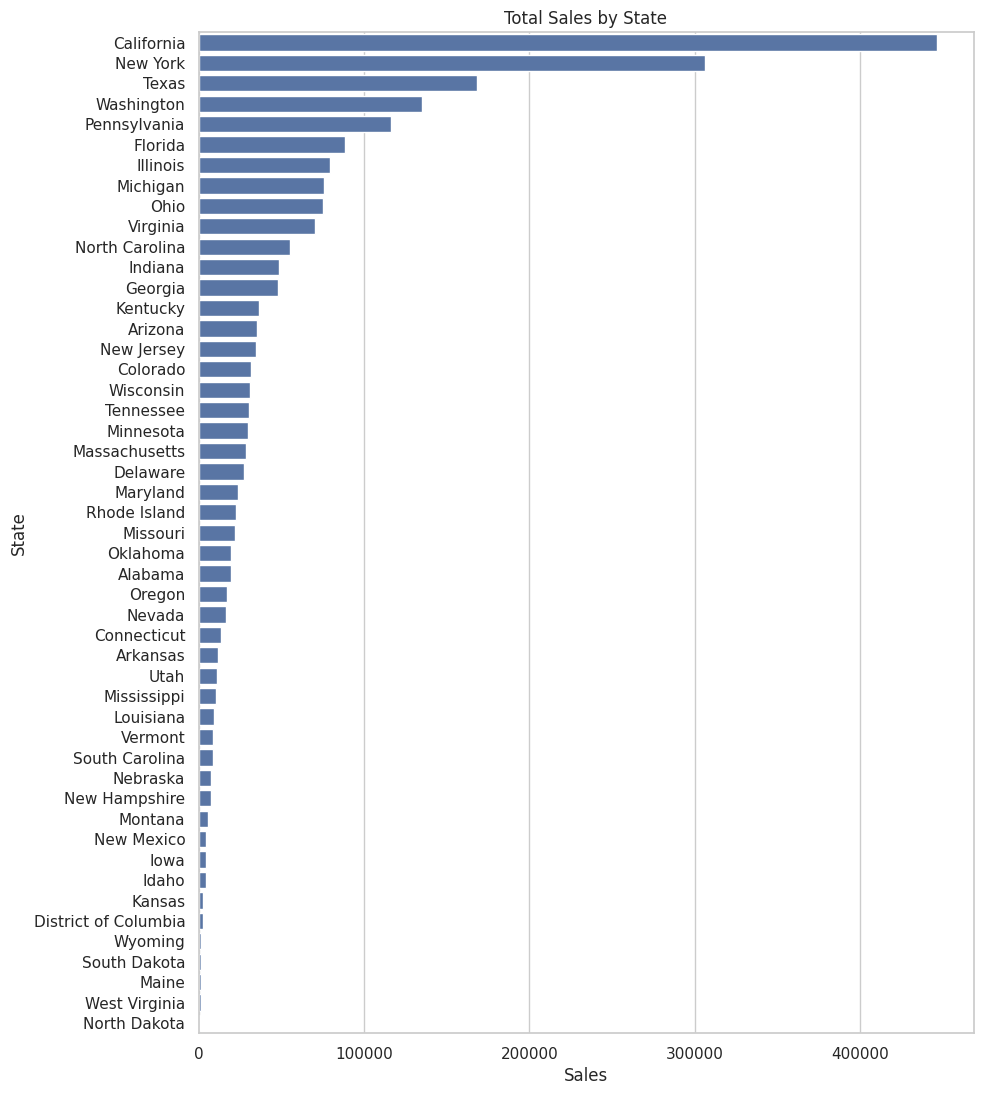

In [92]:
# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('State')['Sales'].sum().reset_index()

sum_of_sales = sum_of_sales.sort_values(by='Sales', ascending=False)

plt.figure(figsize=(10, 13))
ax = sns.barplot(x='Sales', y='State', data=sum_of_sales, ci=None)

plt.xlabel('Sales')
plt.ylabel('State')
plt.title('Total Sales by State')
plt.show()

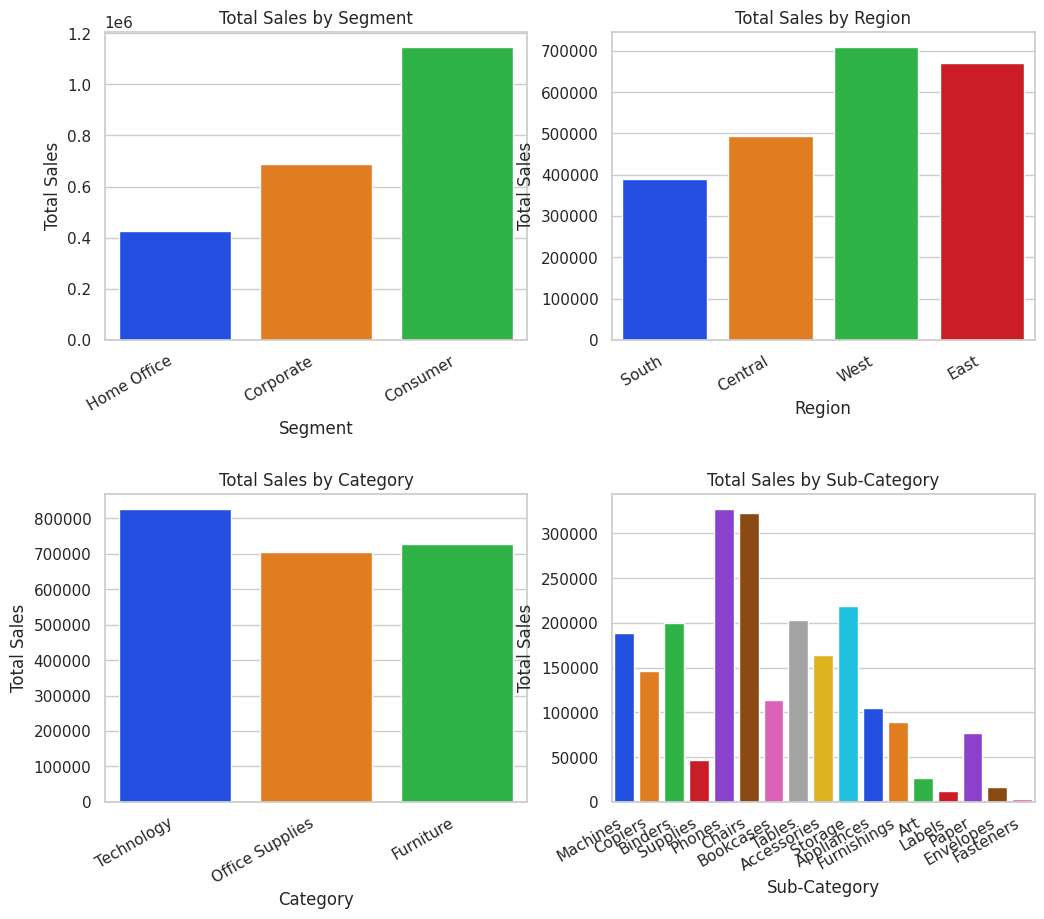

In [93]:
plotdf = df.sort_values(by='Sales', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

columns = ['Segment', 'Region', 'Category', 'Sub-Category']

# Barplots for each column
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.barplot(x=column, y='Sales', data=plotdf, estimator=np.sum, errorbar=None, palette='bright', ax=ax)
    ax.set_ylabel('Total Sales')
    ax.set_title(f'Total Sales by {column}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

## 4. Preprocessing with geographical & categorical features

In [94]:
def preprocess_data(df):
    print("=== Preprocessing data ===")
    data = df.copy()
    
    # Handle missing values
    data = data.dropna()
    
    # Initialize label encoders
    encoders = {}
    
    # Encode geographical features (VERY BENEFICIAL for sales prediction)
    geo_columns = ['Postal Code', 'City', 'State', 'Region', 'Country']
    for col in geo_columns:
        if col in data.columns:
            encoders[col] = LabelEncoder()
            data[f'{col.lower().replace(" ", "_")}_encoded'] = encoders[col].fit_transform(data[col])
            print(f"✓ Encoded {col}: {data[col].nunique()} unique values")
    
    # Encode product hierarchy features (VERY BENEFICIAL for recommendations)
    product_columns = ['Product ID', 'Product Name', 'Category', 'Sub-Category']
    for col in product_columns:
        if col in data.columns:
            encoders[col] = LabelEncoder()
            data[f'{col.lower().replace(" ", "_").replace("-", "_")}_encoded'] = encoders[col].fit_transform(data[col])
            print(f"✓ Encoded {col}: {data[col].nunique()} unique values")
    
    # Encode customer segment
    if 'Segment' in data.columns:
        encoders['Segment'] = LabelEncoder()
        data['segment_encoded'] = encoders['Segment'].fit_transform(data['Segment'])
        print(f"✓ Encoded Segment: {data['Segment'].nunique()} unique values")
    
    return data, encoders

## 5. Feature engineering

In [95]:
def create_advanced_features(data):
    print("\n=== Creating features ===")
    
    # 1. GEOGRAPHICAL FEATURES 
    if 'region_encoded' in data.columns:
        # Regional sales performance
        region_stats = data.groupby('region_encoded')['Sales'].agg(['mean', 'std', 'count']).add_prefix('region_')
        data = data.merge(region_stats, left_on='region_encoded', right_index=True, how='left')
        print("✓ Added regional sales statistics")
    
    if 'city_encoded' in data.columns:
        # City-level market characteristics
        city_stats = data.groupby('city_encoded')['Sales'].agg(['mean', 'median', 'std']).add_prefix('city_')
        data = data.merge(city_stats, left_on='city_encoded', right_index=True, how='left')
        print("✓ Added city-level market features")
    
    # 2. PRODUCT CATEGORY FEATURES 
    if 'category_encoded' in data.columns:
        # Category performance by region
        cat_region_stats = data.groupby(['category_encoded', 'region_encoded'])['Sales'].mean().reset_index()
        cat_region_stats.columns = ['category_encoded', 'region_encoded', 'cat_region_avg_sales']
        data = data.merge(cat_region_stats, on=['category_encoded', 'region_encoded'], how='left')
        print("✓ Added category-region interaction features")
    
    if 'sub_category_encoded' in data.columns:
        # Sub-category market penetration
        subcat_stats = data.groupby('sub_category_encoded').agg({
            'Sales': ['mean', 'std', 'count']
        }).fillna(0)
        subcat_stats.columns = ['subcat_avg_sales', 'subcat_std_sales', 'subcat_frequency']
        data = data.merge(subcat_stats, left_on='sub_category_encoded', right_index=True, how='left')
        print("✓ Added sub-category performance features")
    
    # 3. OUTLET-PRODUCT INTERACTION FEATURES
    if 'postal_code_encoded' in data.columns and 'product_id_encoded' in data.columns:
        # Historical performance of product at outlet
        outlet_product = data.groupby(['postal_code_encoded', 'product_id_encoded']).agg({
            'Sales': ['mean', 'sum', 'count']
        }).fillna(0)
        outlet_product.columns = ['op_avg_sales', 'op_total_sales', 'op_frequency']
        data = data.merge(outlet_product, left_on=['postal_code_encoded', 'product_id_encoded'], right_index=True, how='left')
        print("✓ Added outlet-product interaction features")
        
    # 4. TEMPORAL FEATURES (FIXED DATE PARSING)
    date_columns = ['Order Date', 'Ship Date', 'Date']
    for col in date_columns:
        if col in data.columns:
            try:
                # Try different date formats
                # First attempt: day/month/year format (most likely based on your error)
                data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')
                
                # If that doesn't work, try mixed format parsing
                if data[col].isna().all():
                    data[col] = pd.to_datetime(data[col], format='mixed', dayfirst=True, errors='coerce')
                
                # If still doesn't work, try infer_datetime_format
                if data[col].isna().all():
                    data[col] = pd.to_datetime(data[col], infer_datetime_format=True, errors='coerce')
                
                # Extract temporal features if parsing was successful
                if not data[col].isna().all():
                    data['month'] = data[col].dt.month
                    data['quarter'] = data[col].dt.quarter
                    data['day_of_week'] = data[col].dt.dayofweek
                    data['year'] = data[col].dt.year
                    data['is_weekend'] = (data[col].dt.dayofweek >= 5).astype(int)
                    
                    # Add seasonal features
                    data['season'] = data['month'].map({
                        12: 'Winter', 1: 'Winter', 2: 'Winter',
                        3: 'Spring', 4: 'Spring', 5: 'Spring',
                        6: 'Summer', 7: 'Summer', 8: 'Summer',
                        9: 'Fall', 10: 'Fall', 11: 'Fall'
                    })
                    
                    print(f"✓ Added temporal features from {col}")
                    print(f"  - Date range: {data[col].min()} to {data[col].max()}")
                    break
                else:
                    print(f"⚠ Warning: Could not parse dates in column {col}")
                    
            except Exception as e:
                print(f"⚠ Error parsing dates in {col}: {str(e)}")
            
            break
    
    return data

## 6. Create target variable 

In [96]:
def create_enhanced_target(data):
    print("\n=== Creating target variable ===")
    
    # Multi-factor sales potential score
    factors = {}
    
    # Factor 1: Product's category performance in the region
    if 'category_encoded' in data.columns and 'region_encoded' in data.columns:
        cat_region_performance = data.groupby(['category_encoded', 'region_encoded'])['Sales'].mean()
        data['cat_region_performance'] = data.apply(
            lambda x: cat_region_performance.get((x['category_encoded'], x['region_encoded']), 0), axis=1
        )
        factors['category_regional_fit'] = 0.25
        print("✓ Added category-regional performance factor")
    
    # Factor 2: Product's historical performance
    if 'product_id_encoded' in data.columns:
        product_performance = data.groupby('product_id_encoded')['Sales'].mean()
        data['product_performance'] = data['product_id_encoded'].map(product_performance)
        factors['product_strength'] = 0.25
        print("✓ Added product performance factor")
    
    # Factor 3: Outlet's market characteristics
    if 'postal_code_encoded' in data.columns:
        outlet_performance = data.groupby('postal_code_encoded')['Sales'].mean()
        data['outlet_performance'] = data['postal_code_encoded'].map(outlet_performance)
        factors['outlet_potential'] = 0.25
        print("✓ Added outlet performance factor")
    
    # Factor 4: Current sales (baseline)
    factors['current_sales'] = 0.25
    
    # Calculate weighted sales potential
    data['sales_potential'] = 0
    
    if 'cat_region_performance' in data.columns:
        data['sales_potential'] += factors['category_regional_fit'] * data['cat_region_performance']
    if 'product_performance' in data.columns:
        data['sales_potential'] += factors['product_strength'] * data['product_performance']
    if 'outlet_performance' in data.columns:
        data['sales_potential'] += factors['outlet_potential'] * data['outlet_performance']
    
    data['sales_potential'] += factors['current_sales'] * data['Sales']
    
    print(f"✓ Created sales_potential target (mean: {data['sales_potential'].mean():.2f})")
    return data

## 7. Prepare features for LightGBM

In [97]:
def prepare_features(data):
    print("\n=== Preparing features for LightGBM ===")
    
    # Select all encoded and numerical features
    feature_columns = []
    
    # Geographical features
    geo_features = [col for col in data.columns if any(geo in col for geo in ['postal_code_encoded', 'city_encoded', 'state_encoded', 'region_encoded'])]
    feature_columns.extend(geo_features)
    
    # Product features
    product_features = [col for col in data.columns if any(prod in col for prod in ['product_id_encoded', 'category_encoded', 'sub_category_encoded'])]
    feature_columns.extend(product_features)
    
    # Statistical features
    stat_features = [col for col in data.columns if any(stat in col for stat in ['_mean', '_std', '_avg', '_sum', '_count', '_frequency'])]
    feature_columns.extend(stat_features)
    
    # Numerical features
    numerical_features = ['Discount', 'Sales', 'month', 'quarter', 'day_of_week']
    for col in numerical_features:
        if col in data.columns:
            feature_columns.append(col)
    
    # Customer segment
    if 'segment_encoded' in data.columns:
        feature_columns.append('segment_encoded')
    
    # Remove duplicates and ensure all columns exist
    feature_columns = list(set(feature_columns))
    feature_columns = [col for col in feature_columns if col in data.columns]
    
    print(f"✓ Selected {len(feature_columns)} features for modeling")
    print(f"Features: {feature_columns[:10]}..." if len(feature_columns) > 10 else f"Features: {feature_columns}")
    
    return feature_columns


XGBoost can be slower to train compared to LightGBM, especially on large datasets, and might require more tuning to achieve optimal performance because it is more sensitive to noise or outliers. CatBoost might be preferred when dealing with datasets rich in categorical variables.

I chose LightGBM because it is designed to handle large datasets carries out leaf-wise (vertical) growth that results in more loss reduction and, in turn, higher accuracy while being faster.

For many algorithms, like distance-based models (KNN, SVM...) for instance, feature scaling is compulsory. However, as a tree-based algorithm, LightGBM does not require any feature scaling/normalization/standardization method to perform well. This is because at each tree level, the score of a possible split will be equal. 


## 8. Main execution

In [103]:
# Preprocess data
processed_data, encoders = preprocess_data(df)

# Create features
processed_data = create_advanced_features(processed_data)

# Create target variable
processed_data = create_enhanced_target(processed_data)

# Prepare features
feature_columns = prepare_features(processed_data)

# Prepare data for modeling
X = processed_data[feature_columns].fillna(0)
y = processed_data['sales_potential']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n=== Split ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

=== Preprocessing data ===
✓ Encoded Postal Code: 626 unique values
✓ Encoded City: 529 unique values
✓ Encoded State: 48 unique values
✓ Encoded Region: 4 unique values
✓ Encoded Country: 1 unique values
✓ Encoded Product ID: 1860 unique values
✓ Encoded Product Name: 1848 unique values
✓ Encoded Category: 3 unique values
✓ Encoded Sub-Category: 17 unique values
✓ Encoded Segment: 3 unique values

=== Creating features ===
✓ Added regional sales statistics
✓ Added city-level market features
✓ Added category-region interaction features
✓ Added sub-category performance features
✓ Added outlet-product interaction features
✓ Added temporal features from Order Date
  - Date range: 2015-01-03 00:00:00 to 2018-12-30 00:00:00

=== Creating target variable ===
✓ Added category-regional performance factor
✓ Added product performance factor
✓ Added outlet performance factor
✓ Created sales_potential target (mean: 230.12)

=== Preparing features for LightGBM ===
✓ Selected 23 features for modelin

## 9. Training the model

In [104]:
# LightGBM parameters optimized for ranking/recommendation
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Dictionary to store evaluation results
evals_result = {}

# Train model with evaluation tracking
model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['training', 'valid_0'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evals_result)
    ]
)

# Store evaluation results in model for later access
model.evals_result_ = evals_result

print(f"\n✓ LightGBM model trained successfully")
print(f"✓ Training completed at iteration {model.best_iteration}")
print(f"✓ Final training RMSE: {evals_result['training']['rmse'][-1]:.4f}")
print(f"✓ Final validation RMSE: {evals_result['valid_0']['rmse'][-1]:.4f}")
    

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 104.674	valid_0's rmse: 122.407
Early stopping, best iteration is:
[137]	training's rmse: 97.1628	valid_0's rmse: 121.53

✓ LightGBM model trained successfully
✓ Training completed at iteration 137
✓ Final training RMSE: 84.5193
✓ Final validation RMSE: 126.0115


## 10. Model evaluation

=== MODEL PERFORMANCE METRICS ===
Root Mean Squared Error (RMSE): 121.5298
Mean Absolute Error (MAE): 30.9091
R² Score: 0.8746


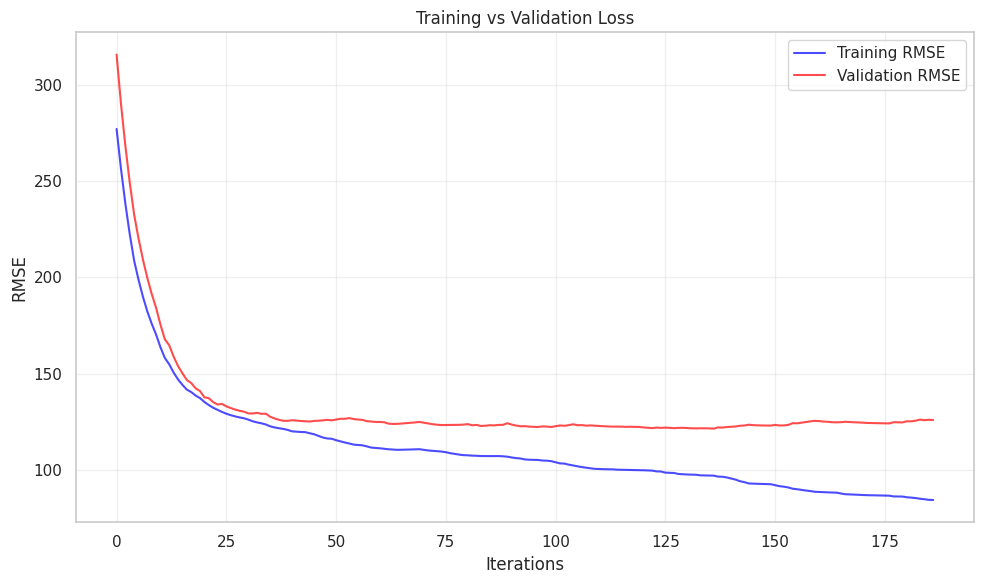

Best iteration: 137


In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Get predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate basic regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"=== MODEL PERFORMANCE METRICS ===")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

def plot_training_history(model):
    """Plot training and validation loss over iterations"""
    try:
        # Check if model has evaluation history
        if hasattr(model, 'evals_result_') and model.evals_result_:
            # Get training and validation results
            results = model.evals_result_
            
            plt.figure(figsize=(10, 6))
            
            # Plot training loss if available
            if 'training' in results and 'rmse' in results['training']:
                train_loss = results['training']['rmse']
                plt.plot(range(len(train_loss)), train_loss, label='Training RMSE', color='blue', alpha=0.7)
            
            # Plot validation loss if available
            if 'valid_0' in results and 'rmse' in results['valid_0']:
                val_loss = results['valid_0']['rmse']
                plt.plot(range(len(val_loss)), val_loss, label='Validation RMSE', color='red', alpha=0.7)
            
            plt.xlabel('Iterations')
            plt.ylabel('RMSE')
            plt.title('Training vs Validation Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"Best iteration: {model.best_iteration}")
        else:
            print("No training history available. Model wasn't trained with validation tracking.")
            
    except Exception as e:
        print(f"Could not plot training history: {e}")
        print("Training completed without detailed logging.")

# Plot training history
plot_training_history(model)

The gap between the training and validation RMSE indicates moderate overfitting. The curves suggest acceptable generalization. Although training loss continues to drop, the validation curve doesn't worsen sharply.

RMSE measures how far my model’s predictions are from the actual values in the same unit as the output I'm predicting. My actual sales values range from 0 to over 6000+ so an RMSE of ~121 is quite reasonable. 

MAE = 30.91 confirms reasonably accurate predictions on average.

R² = 0.875 means ~87.5% of the variation in sales potential is explained by the model, which is still strong performance. Because usually high R² around 0.70 to 0.99 indicate a strong correlation and a model that explains a large portion of the variance. 

In [106]:
# Simple ranking evaluation
def calculate_top_k_accuracy(y_true, y_pred, k):
    """Calculate how often top-k predictions contain the best actual values"""
    # Get indices of top-k predictions and actual values
    top_k_pred_indices = np.argsort(y_pred)[-k:]
    top_k_true_indices = np.argsort(y_true)[-k:]
    
    # Calculate overlap
    overlap = len(set(top_k_pred_indices) & set(top_k_true_indices))
    accuracy = overlap / k
    return accuracy

# Calculate ranking metrics
print(f"=== RANKING PERFORMANCE ===")
top5_accuracy = calculate_top_k_accuracy(y_test, y_pred, k=5)
top10_accuracy = calculate_top_k_accuracy(y_test, y_pred, k=10)

print(f"Top-5 Recommendation Accuracy: {top5_accuracy:.2%}")
print(f"Top-10 Recommendation Accuracy: {top10_accuracy:.2%}")

=== RANKING PERFORMANCE ===
Top-5 Recommendation Accuracy: 80.00%
Top-10 Recommendation Accuracy: 80.00%


=== TOP 10 MOST IMPORTANT FEATURES ===
Sales: 1325377316.1424713
op_avg_sales: 1094935099.538391
subcat_frequency: 68988706.22836304
cat_region_avg_sales: 53407065.938201904
city_std: 50008938.53314209
city_mean: 42463025.87138367
product_id_encoded: 36896237.24319458
postal_code_encoded: 25986298.5289917
subcat_avg_sales: 21621929.64175415
day_of_week: 21152769.263031006


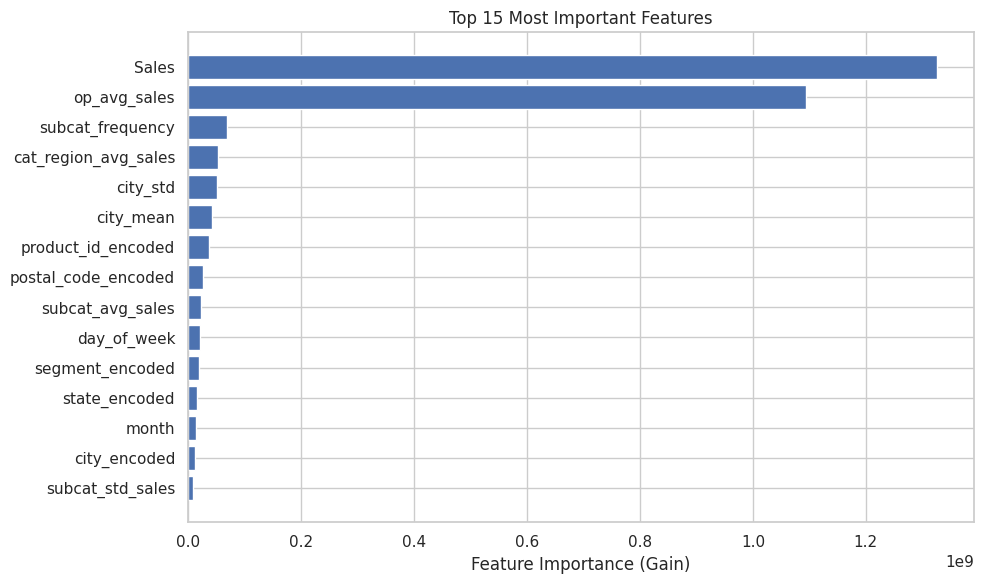

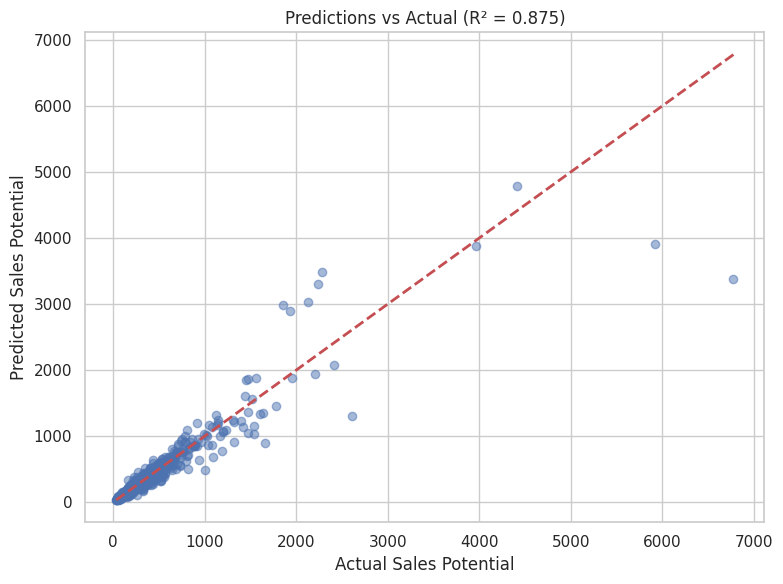

In [107]:
# Feature importance
importance = model.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print(f"=== TOP 10 MOST IMPORTANT FEATURES ===")
for i, row in feature_imp.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']}")

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_imp.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Prediction vs Actual scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales Potential')
plt.ylabel('Predicted Sales Potential')
plt.title(f'Predictions vs Actual (R² = {r2:.3f})')
plt.tight_layout()
plt.show()

The model heavily depends on historical sales data, both at product and regional levels. Geographic and temporal features like day_of_week and postal_code_encoded also contribute, but to a lesser extent.

In the scatter plot, most points cluster tightly along the diagonal line, showing accurate predictions. The few outliers suggest the model might under- or overestimate sales potential as when actual sales potential is higher.

Seems that some data points are separated far from each other which might be what's giving me a higher RMSE value.

The model performs well overall, though there’s some noise in higher sales ranges. Could be due to product launches, discounts, or regional anomalies not captured by current features.

## 11. Recommendation function

In [115]:
def get_enhanced_product_rankings(postal_code, top_k=10):
    """Get product rankings for a specific outlet with enhanced features"""
    
    # Find outlet encoding
    if 'Postal Code' not in encoders:
        print("Error: Postal Code encoder not found")
        return pd.DataFrame()
    
    try:
        outlet_encoded = encoders['Postal Code'].transform([postal_code])[0]
    except:
        print(f"Error: Postal code {postal_code} not found in training data")
        return pd.DataFrame()
        
    # Get all unique products
    unique_products = processed_data['product_id_encoded'].unique()
    
    # Create prediction dataset for this outlet
    pred_data = []
    
    for product in unique_products:
        # Create base record
        record = {'postal_code_encoded': outlet_encoded, 'product_id_encoded': product}
        
        # Add geographical features for this outlet
        outlet_data = processed_data[processed_data['postal_code_encoded'] == outlet_encoded].iloc[0]
        for col in ['region_encoded', 'city_encoded', 'state_encoded']:
            if col in processed_data.columns:
                record[col] = outlet_data[col]
            
        # Add product features
        product_data = processed_data[processed_data['product_id_encoded'] == product].iloc[0]
        for col in ['category_encoded', 'sub_category_encoded']:
            if col in processed_data.columns:
                record[col] = product_data[col]
        
        pred_data.append(record)
    
    pred_df = pd.DataFrame(pred_data)
    
    # Add computed features (using training data statistics)
    for col in feature_columns:
        if col not in pred_df.columns:
            if col in processed_data.columns:
                # Use mean value for missing features
                pred_df[col] = processed_data[col].mean()
            else:
                pred_df[col] = 0
    
    # Ensure all feature columns are present
    for col in feature_columns:
        if col not in pred_df.columns:
            pred_df[col] = 0
    
    pred_df = pred_df[feature_columns].fillna(0)
    
    # Predict sales potential
    predictions = model.predict(pred_df, num_iteration=model.best_iteration)
    
    # Create ranking
    ranking_df = pd.DataFrame({
        'product_encoded': unique_products,
        'predicted_potential': predictions
    })
    
    # Convert back to original product IDs
    original_products = encoders['Product ID'].inverse_transform(unique_products)
    ranking_df['Product_ID'] = original_products
    
    # Add category information if available
    if 'Category' in encoders:
        # Get categories for products
        product_categories = []
        for prod_enc in unique_products:
            prod_data = processed_data[processed_data['product_id_encoded'] == prod_enc]
            if len(prod_data) > 0:
                cat_enc = prod_data['category_encoded'].iloc[0]
                category = encoders['Category'].inverse_transform([cat_enc])[0]
                product_categories.append(category)
            else:
                product_categories.append('Unknown')
        ranking_df['Category'] = product_categories
    
   # Add historical sales for tie-breaking
    historical_sales = []
    for prod in unique_products:
        sales = processed_data[processed_data['product_id_encoded'] == prod]['Sales'].mean()
        historical_sales.append(sales)
    ranking_df['historical_sales'] = historical_sales
    
    # Sort by predicted potential, then historical sales (both descending)
    ranking_df = ranking_df.sort_values(['predicted_potential', 'historical_sales'], ascending=[False, False])
    
    return ranking_df.head(top_k)

In [116]:
print(f"=== PRODUCT RANKINGS ===")
    
# Get sample postal codes
sample_postal_codes = df['Postal Code'].unique()[:3] if 'Postal Code' in df.columns else []

for postal_code in sample_postal_codes:
    print(f"\nTop 10 recommended products for outlet {round(postal_code)}:")
    rankings = get_enhanced_product_rankings(postal_code, top_k=10)
    
    if not rankings.empty:
        for idx, row in rankings.iterrows():
            category_info = f" ({row['Category']})" if 'Category' in rankings.columns else ""
            print(f"{len(rankings) - list(rankings.index).index(idx)}. Product {row['Product_ID']}{category_info} - Score: {row['predicted_potential']:.2f}")
    else:
        print("No recommendations available")


=== PRODUCT RANKINGS ===

Top 10 recommended products for outlet 42420:
10. Product TEC-PH-10004241 (Technology) - Score: 232.46
9. Product TEC-PH-10004165 (Technology) - Score: 232.46
8. Product TEC-PH-10004120 (Technology) - Score: 232.46
7. Product TEC-PH-10004389 (Technology) - Score: 232.46
6. Product TEC-PH-10004345 (Technology) - Score: 232.46
5. Product TEC-PH-10004188 (Technology) - Score: 232.46
4. Product TEC-PH-10004348 (Technology) - Score: 232.46
3. Product TEC-PH-10004539 (Technology) - Score: 230.96
2. Product TEC-PH-10004536 (Technology) - Score: 230.96
1. Product TEC-PH-10004434 (Technology) - Score: 230.96

Top 10 recommended products for outlet 90036:
10. Product FUR-CH-10000749 (Furniture) - Score: 226.94
9. Product FUR-CH-10000454 (Furniture) - Score: 226.94
8. Product FUR-CH-10000595 (Furniture) - Score: 226.94
7. Product FUR-CH-10000513 (Furniture) - Score: 226.94
6. Product FUR-CH-10000665 (Furniture) - Score: 226.94
5. Product FUR-CH-10000553 (Furniture) - Sco